In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# Model: xgboost

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from xgboost.sklearn import XGBClassifier

## Data

Load the dataset, applying no major transformations to it.

In [15]:
data = pd.read_csv('../dataset/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [16]:
X = data.drop(columns=['Class'])
y = data['Class']

Since the data is largely unbalanced we must use a stratified sampling to make sure we get both negative and positive samples to train with.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)

## Pipeline (build)

In [18]:
numeric_feature_indexes = slice(0, 30)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_feature_indexes),
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

In [19]:
num_features_type_map = {feature: 'float64' for feature in X_train.columns[numeric_feature_indexes]}

X_train = X_train.astype(num_features_type_map)
X_test = X_test.astype(num_features_type_map)

## Pipeline (train)

In [20]:
model = pipeline.fit(X_train, y_train, classifier__eval_metric='auc')
model 

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  slice(0, 30, None))],
                                   verbose=False)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsamp...
                               interaction_constraints=None,
                               learning_rate=0.300000012, max_delta_step=0,

## Pipeline (evaluate)

In [21]:
y_pred = model.predict(X_test)

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.95      0.77      0.85       162

    accuracy                           1.00     93987
   macro avg       0.98      0.89      0.93     93987
weighted avg       1.00      1.00      1.00     93987



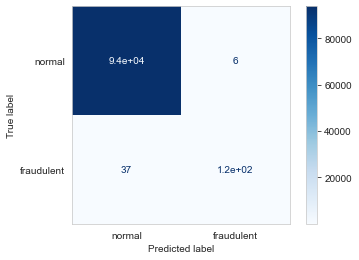

In [23]:
disp = plot_confusion_matrix(model, X_test, y_test, display_labels=['normal', 'fraudulent'], cmap=plt.cm.Blues)
disp.ax_.grid(False)

Some great material is available here: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

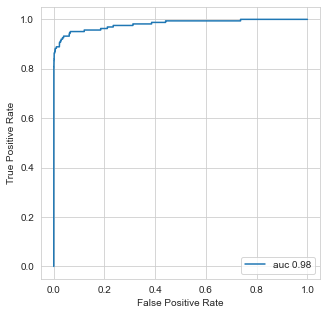

In [30]:
y_pred_proba = pipeline.predict_proba(X_test)[::,1]

fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(fpr,tpr,label=f"auc {auc:2.2f}")
ax.legend(loc=4)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate');

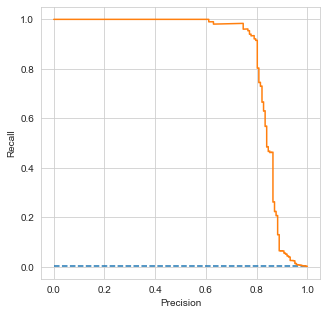

In [39]:
precision, recall, _ = precision_recall_curve(y_test,  y_pred_proba)
fig, ax = plt.subplots(figsize=(5,5))

no_skill = len(y_test[y_test==1]) / len(y_test)
ax.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
ax.plot(recall, precision)

ax.set_xlabel('Precision')
ax.set_ylabel('Recall');